In [2]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

ERROR 1: PROJ: proj_create_from_database: Open of /dartfs-hpc/rc/home/0/f004260/.conda/envs/arg24/share/proj failed


In [3]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')

In [4]:
gdf = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))
gdf_st = gdf.dissolve(by='state')

In [5]:
lnd = pd.read_csv(os.path.join(project_dir,'data','raw','lnd_full_clean_2024-12-31.csv'))
lnd = lnd[lnd['weight_type']=='Population']
lnd = lnd[lnd['fips'].notnull()]
lnd['county'] = lnd['fips'].astype(int)
lnd['begin_date'] = pd.to_datetime(lnd['begin_date'])
lnd['year'] = lnd['begin_date'].dt.year
lnd['month'] = lnd['begin_date'].dt.month

import pickle
with open(os.path.join(project_dir,'data','interim','va_fips_crosswalk.pkl'),'rb') as src:
    va_crosswalk = pickle.load(src)
    
lnd['county'] = lnd['county'].replace(va_crosswalk)
cnty_dmg = lnd.groupby(['county','year','disaster_group'])[['damages_total_adj']].sum() # sum damage
cnty_dmg_ds = xr.Dataset.from_dataframe(cnty_dmg).sel(year=slice(2003,2024))
n_dmg_yr = (cnty_dmg_ds.sel(disaster_group=['Flood','Hurricane/Tropical Storm']).sum('disaster_group')>1e3).sum("year")
n_dmg_df = gdf.merge(n_dmg_yr.to_dataframe().reset_index(),on='county')

In [6]:
# FEMA disaster declarations 
dis_dec = pd.read_csv(os.path.join(project_dir,'data','raw','DisasterDeclarationsSummaries.csv'))
dis_dec = dis_dec[dis_dec['fipsCountyCode']!=0]
dis_dec['county'] = dis_dec['fipsStateCode'].astype(str)+dis_dec['fipsCountyCode'].astype(str).str.zfill(3)
dis_dec['county'] = dis_dec['county'].astype(int)
dis_dec['county'] = dis_dec['county'].replace(va_crosswalk)
dis_dec['incidentBeginDate'] = pd.to_datetime(dis_dec['incidentBeginDate'])
dis_dec['decl'] = 1
dis_dec = dis_dec[dis_dec['incidentBeginDate'].dt.year>=2003]
dis_dec['flood_decl'] = ((dis_dec['declarationTitle'].str.contains("FLOOD"))|(dis_dec['designatedIncidentTypes'].str.contains("F"))|(dis_dec['incidentType'].isin(['Hurricane','Tropical Storm']))).astype(int)
dis_dec.loc[dis_dec['declarationTitle'].str.contains("EVACUATION"),'flood_decl']=0
dis_dec.loc[dis_dec['declarationTitle'].str.contains("EVACUEES"),'flood_decl']=0
dis_dec['time'] = dis_dec['incidentBeginDate'].apply(lambda x: datetime(x.year,x.month,x.day))
dis_dec_ds = xr.Dataset.from_dataframe(dis_dec.groupby(['county','time'])[['flood_decl']].max()).groupby('time.year').max().sel(year=slice(2003,2024))

In [7]:
dis_dec_df = gdf.merge(dis_dec_ds.sum('year').to_dataframe().reset_index(),on='county')

In [8]:
nfip = xr.open_dataset(os.path.join(project_dir,'data','interim','nfip_dmg_mon_county.nc'))
nfip_df = gdf.merge((nfip.groupby("time.year").max()>5).sum('year').to_dataframe().reset_index(),on='county',how='left')
nfip_df['claims'].fillna(0,inplace=True)

In [9]:
usgs_flood = xr.open_dataset(os.path.join(project_dir,'data','interim','usgs_flood.nc')).rename({"peak_dt":"time"}).groupby("time.year").max()
usgs_flood = usgs_flood.where(usgs_flood['yrs_w_obs']>=15,drop=True)
usgs_flood_coords = usgs_flood[['latitude','longitude']].to_dataframe()
usgs_flood_coords['geometry'] = usgs_flood_coords.apply(lambda row: Point(row['longitude'],row['latitude']),axis=1)

gage_flood_df = usgs_flood_coords.reset_index().merge(usgs_flood['flood'].sum('year').to_dataframe().reset_index(),on='site_no')
gage_flood_df = gpd.GeoDataFrame(gage_flood_df)

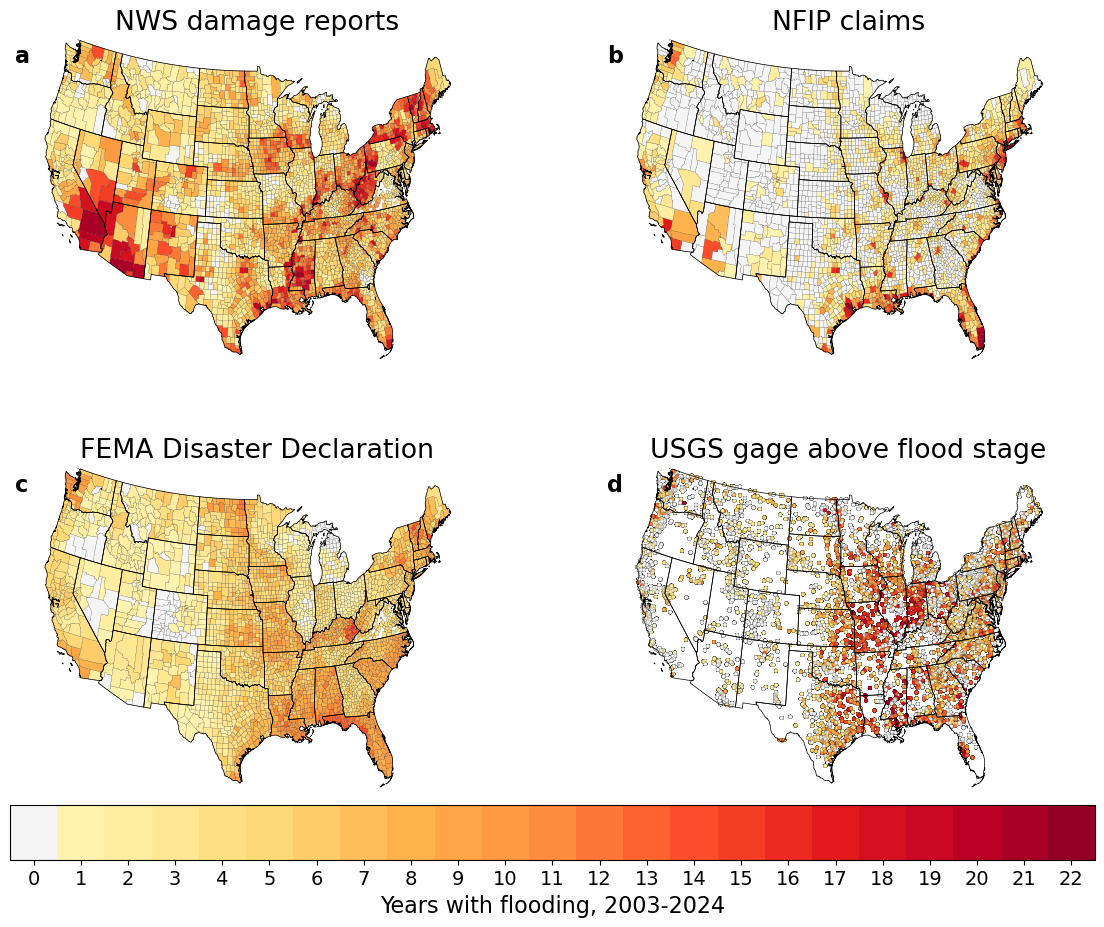

In [11]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 16,
                     'axes.labelsize':16})
plt.rc('xtick', labelsize=14) # Set x-axis tick label size
plt.rc('ytick', labelsize=14) # Set y-axis tick label size
levels = np.arange(-0.5,23.5,1)
yr_cols = sns.color_palette("YlOrRd",len(levels)-1)
yr_cols[0] = 'whitesmoke'
yr_cmap = mpl.colors.ListedColormap(yr_cols)

yr_norm = plt.Normalize(vmin=-0.5,vmax=22.5)

fig = plt.figure(figsize=(14,12))
gs = gridspec.GridSpec(nrows=2,ncols=2,figure=fig)
ax1 = plt.subplot(gs[0,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
n_dmg_df.plot(column='damages_total_adj',ax=ax1,transform=ccrs.PlateCarree(),cmap=yr_cmap,norm=yr_norm,edgecolor='black',lw=0.1)
ax1.title.set_text("NWS damage reports")
asp = ax1.get_aspect()

ax2 = plt.subplot(gs[0,1],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
nfip_df.plot(column='claims',ax=ax2,transform=ccrs.PlateCarree(),cmap=yr_cmap,norm=yr_norm,edgecolor='black',lw=0.1)
ax2.title.set_text("NFIP claims")

ax3 = plt.subplot(gs[1,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
dis_dec_df.plot(column='flood_decl',ax=ax3,transform=ccrs.PlateCarree(),cmap=yr_cmap,norm=yr_norm,edgecolor='black',lw=0.1)
ax3.title.set_text("FEMA Disaster Declaration")

ax4 = plt.subplot(gs[1,1],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
gage_flood_df.plot(column='flood',ax=ax4,transform=ccrs.PlateCarree(),cmap=yr_cmap,norm=yr_norm,s=7,edgecolor='black',lw=0.1)
ax4.title.set_text("USGS gage above flood stage")
ax4.set_aspect(asp)

yr_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=yr_norm,cmap=yr_cmap),ax=[ax1,ax2,ax3,ax4],orientation='horizontal',ticks=levels+0.5,pad=0.0,)
yr_cbar.ax.set_xlabel('Years with flooding, 2003-2024')

labels = ['a','b','c','d']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.set_extent([-123, -68, 24, 49],ccrs.PlateCarree())
    ax.text(0.01,0.98,labels[i],ha='left',va='top',fontsize=16,fontweight='bold',transform=ax.transAxes)
    ax.set_frame_on(False)
    gdf_st.geometry.boundary.plot(ax=ax,transform=ccrs.PlateCarree(),lw=0.5,color='black')

plt.savefig(os.path.join(project_dir,'figures','supp_mat','flood_indicators.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'figures','supp_mat','flood_indicators.pdf'),bbox_inches='tight',dpi=350)
plt.show()

<Axes: >

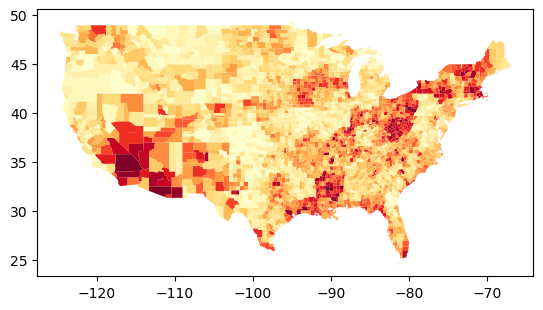

In [14]:
n_dmg_df.plot(column='damages_total_adj',cmap='YlOrRd',vmin=0,vmax=20)

In [76]:
dis_dec_df

,county,name,state,geometry,flood_decl
0,53073,Whatcom County,WA,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532...",6.0
1,53047,Okanogan County,WA,"POLYGON ((-120.85196 48.99251, -120.67495 48.9...",5.0
2,53019,Ferry County,WA,"POLYGON ((-118.83688 48.99251, -118.69668 48.9...",2.0
3,53065,Stevens County,WA,"POLYGON ((-118.21996 48.99251, -118.03723 48.9...",1.0
4,53051,Pend Oreille County,WA,"POLYGON ((-117.42951 48.99251, -117.37787 48.9...",4.0
...,...,...,...,...,...
3074,51949,Southampton County,VA,"POLYGON ((-76.91506 36.70073, -76.92042 36.681...",6.0
3075,51951,Spotsylvania County,VA,"POLYGON ((-77.50485 38.11954, -77.64215 37.991...",4.0
3076,51953,Washington County,VA,"POLYGON ((-82.20915 36.59805, -82.24337 36.598...",3.0
3077,51955,Wise County,VA,"POLYGON ((-82.55121 37.19605, -82.54624 37.125...",4.0
